In [1]:
%reload_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import tie.dbutils as db
import pandas as pd
from scipy.io import savemat, loadmat
import json
import os
from tqdm import notebook
from collections import Counter
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.cluster import AgglomerativeClustering
from joblib import dump, load
import itertools
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib.gridspec import GridSpec
from scipy.stats import entropy
from xgboost import cv
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle as pkl
import seaborn as sns

import copy

from scipy.io import loadmat
np.random.seed(42)
import matplotlib.pyplot as plt
import statsmodels.api as sm

# load data

In [2]:
data = loadmat(f'./age_model_1_data_20_v5.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_all', 'd_all', 'e_all', 'g_all', 'n_all', 'p_all', 's_all', 't_all', 'td_all', 'u_all', 'y_all'])

In [15]:
set(np.squeeze(data['g_all']))

{1, 2, 3, 4, 999}

In [3]:
X_sp = np.squeeze(data['X_all'])
a_sp = np.squeeze(data['y_all'])
g_sp = np.squeeze(data['g_all'])
u_sp = np.squeeze(data['u_all'])
e_sp = np.squeeze(data['e_all'])
d_sp = np.squeeze(data['d_all'])
n_sp = np.squeeze(data['n_all'])
s_sp = np.squeeze(data['s_all'])
p_sp = np.squeeze(data['p_all'])
td_sp = np.squeeze(data['td_all'])
p_sp = np.array([a[0] for a in p_sp])
w = 10
X_sp = X_sp[d_sp >= w]
a_sp = a_sp[d_sp >= w]
g_sp = g_sp[d_sp >= w]
u_sp = u_sp[d_sp >= w]
e_sp = e_sp[d_sp >= w]
n_sp = n_sp[d_sp >= w]
s_sp = s_sp[d_sp >= w]
p_sp = p_sp[d_sp >= w]
td_sp = td_sp[d_sp >= w]
d_sp = d_sp[d_sp >= w]


print((X_sp.shape, a_sp.shape, g_sp.shape, u_sp.shape, e_sp.shape, d_sp.shape, n_sp.shape, s_sp.shape, td_sp.shape))

((2703, 2500), (2703,), (2703,), (2703,), (2703,), (2703,), (2703,), (2703,), (2703,))


In [9]:
train_ids = []
test_ids = []

dict_pi = {}
for i, (_p, _d, _a, _g) in enumerate(zip(p_sp, td_sp, a_sp, g_sp)):
    if _p not in dict_pi:
        dict_pi[_p] = [1, _d, [i], _a, _g]
    else:
        dict_pi[_p][0] += 1 
        dict_pi[_p][2].append(i) 

test_dict = {}
train_dict = {}

for k, v in dict_pi.items():
    if v[1] >= 490:
        test_dict[k] = v
    else:
        train_dict[k] = v   
        
print(f"Train: people = {len(train_dict)} | tests = {sum([v[0] for k,v in train_dict.items()])}")
print(f"Test: people = {len(test_dict)} | tests = {sum([v[0] for k,v in test_dict.items()])}")

train_ids = []
test_ids = []
for k, v in train_dict.items():
    train_ids.extend(v[2])
for k, v in test_dict.items():
    test_ids.extend(v[2])
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)
len(train_ids), len(test_ids)

Train: people = 568 | tests = 1756
Test: people = 100 | tests = 947


(1756, 947)

In [12]:
ggg = [g[4] for g in dict_pi.values()]

In [13]:
Counter(ggg)

Counter({2: 331, 999: 9, 1: 166, 3: 76, 4: 86})

In [14]:
aa = Counter(p_sp)
aa[max(aa)], aa[min(aa)], len(aa)

(15, 1, 668)

In [7]:
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

X = np.concatenate([X_sp, g_sp[:, None], np.log10(u_sp[:, None]), e_sp[:, None], s_sp[:, None]], axis=1)
Y = a_sp
X.shape, Y.shape

((3813, 2504), (3813,))

In [8]:
params = {"objective":"reg:squarederror", 'tree_method': 'gpu_hist',
          'colsample_bytree': 1,'learning_rate': 0.1, 
           'subsample':1, 'max_depth': 4, 'gamma': 0,
          'reg_alpha': 0.01, 'reg_lambda': 0.01, 'min_split_loss': 0.0, 'min_child_weight': 0, 'scale_pos_weight': 0}

In [9]:
rfe2 = RFE(xgb.XGBRegressor(tree_method='gpu_hist'), verbose=1, step=1, n_features_to_select=250)
rfe2.fit(X, Y) # only age

Fitting estimator with 2504 features.
Fitting estimator with 2503 features.
Fitting estimator with 2502 features.
Fitting estimator with 2501 features.
Fitting estimator with 2500 features.
Fitting estimator with 2499 features.
Fitting estimator with 2498 features.
Fitting estimator with 2497 features.
Fitting estimator with 2496 features.
Fitting estimator with 2495 features.
Fitting estimator with 2494 features.
Fitting estimator with 2493 features.
Fitting estimator with 2492 features.
Fitting estimator with 2491 features.
Fitting estimator with 2490 features.
Fitting estimator with 2489 features.
Fitting estimator with 2488 features.
Fitting estimator with 2487 features.
Fitting estimator with 2486 features.
Fitting estimator with 2485 features.
Fitting estimator with 2484 features.
Fitting estimator with 2483 features.
Fitting estimator with 2482 features.
Fitting estimator with 2481 features.
Fitting estimator with 2480 features.
Fitting estimator with 2479 features.
Fitting esti

Fitting estimator with 2288 features.
Fitting estimator with 2287 features.
Fitting estimator with 2286 features.
Fitting estimator with 2285 features.
Fitting estimator with 2284 features.
Fitting estimator with 2283 features.
Fitting estimator with 2282 features.
Fitting estimator with 2281 features.
Fitting estimator with 2280 features.
Fitting estimator with 2279 features.
Fitting estimator with 2278 features.
Fitting estimator with 2277 features.
Fitting estimator with 2276 features.
Fitting estimator with 2275 features.
Fitting estimator with 2274 features.
Fitting estimator with 2273 features.
Fitting estimator with 2272 features.
Fitting estimator with 2271 features.
Fitting estimator with 2270 features.
Fitting estimator with 2269 features.
Fitting estimator with 2268 features.
Fitting estimator with 2267 features.
Fitting estimator with 2266 features.
Fitting estimator with 2265 features.
Fitting estimator with 2264 features.
Fitting estimator with 2263 features.
Fitting esti

Fitting estimator with 2072 features.
Fitting estimator with 2071 features.
Fitting estimator with 2070 features.
Fitting estimator with 2069 features.
Fitting estimator with 2068 features.
Fitting estimator with 2067 features.
Fitting estimator with 2066 features.
Fitting estimator with 2065 features.
Fitting estimator with 2064 features.
Fitting estimator with 2063 features.
Fitting estimator with 2062 features.
Fitting estimator with 2061 features.
Fitting estimator with 2060 features.
Fitting estimator with 2059 features.
Fitting estimator with 2058 features.
Fitting estimator with 2057 features.
Fitting estimator with 2056 features.
Fitting estimator with 2055 features.
Fitting estimator with 2054 features.
Fitting estimator with 2053 features.
Fitting estimator with 2052 features.
Fitting estimator with 2051 features.
Fitting estimator with 2050 features.
Fitting estimator with 2049 features.
Fitting estimator with 2048 features.
Fitting estimator with 2047 features.
Fitting esti

Fitting estimator with 1856 features.
Fitting estimator with 1855 features.
Fitting estimator with 1854 features.
Fitting estimator with 1853 features.
Fitting estimator with 1852 features.
Fitting estimator with 1851 features.
Fitting estimator with 1850 features.
Fitting estimator with 1849 features.
Fitting estimator with 1848 features.
Fitting estimator with 1847 features.
Fitting estimator with 1846 features.
Fitting estimator with 1845 features.
Fitting estimator with 1844 features.
Fitting estimator with 1843 features.
Fitting estimator with 1842 features.
Fitting estimator with 1841 features.
Fitting estimator with 1840 features.
Fitting estimator with 1839 features.
Fitting estimator with 1838 features.
Fitting estimator with 1837 features.
Fitting estimator with 1836 features.
Fitting estimator with 1835 features.
Fitting estimator with 1834 features.
Fitting estimator with 1833 features.
Fitting estimator with 1832 features.
Fitting estimator with 1831 features.
Fitting esti

Fitting estimator with 1640 features.
Fitting estimator with 1639 features.
Fitting estimator with 1638 features.
Fitting estimator with 1637 features.
Fitting estimator with 1636 features.
Fitting estimator with 1635 features.
Fitting estimator with 1634 features.
Fitting estimator with 1633 features.
Fitting estimator with 1632 features.
Fitting estimator with 1631 features.
Fitting estimator with 1630 features.
Fitting estimator with 1629 features.
Fitting estimator with 1628 features.
Fitting estimator with 1627 features.
Fitting estimator with 1626 features.
Fitting estimator with 1625 features.
Fitting estimator with 1624 features.
Fitting estimator with 1623 features.
Fitting estimator with 1622 features.
Fitting estimator with 1621 features.
Fitting estimator with 1620 features.
Fitting estimator with 1619 features.
Fitting estimator with 1618 features.
Fitting estimator with 1617 features.
Fitting estimator with 1616 features.
Fitting estimator with 1615 features.
Fitting esti

Fitting estimator with 1424 features.
Fitting estimator with 1423 features.
Fitting estimator with 1422 features.
Fitting estimator with 1421 features.
Fitting estimator with 1420 features.
Fitting estimator with 1419 features.
Fitting estimator with 1418 features.
Fitting estimator with 1417 features.
Fitting estimator with 1416 features.
Fitting estimator with 1415 features.
Fitting estimator with 1414 features.
Fitting estimator with 1413 features.
Fitting estimator with 1412 features.
Fitting estimator with 1411 features.
Fitting estimator with 1410 features.
Fitting estimator with 1409 features.
Fitting estimator with 1408 features.
Fitting estimator with 1407 features.
Fitting estimator with 1406 features.
Fitting estimator with 1405 features.
Fitting estimator with 1404 features.
Fitting estimator with 1403 features.
Fitting estimator with 1402 features.
Fitting estimator with 1401 features.
Fitting estimator with 1400 features.
Fitting estimator with 1399 features.
Fitting esti

Fitting estimator with 1208 features.
Fitting estimator with 1207 features.
Fitting estimator with 1206 features.
Fitting estimator with 1205 features.
Fitting estimator with 1204 features.
Fitting estimator with 1203 features.
Fitting estimator with 1202 features.
Fitting estimator with 1201 features.
Fitting estimator with 1200 features.
Fitting estimator with 1199 features.
Fitting estimator with 1198 features.
Fitting estimator with 1197 features.
Fitting estimator with 1196 features.
Fitting estimator with 1195 features.
Fitting estimator with 1194 features.
Fitting estimator with 1193 features.
Fitting estimator with 1192 features.
Fitting estimator with 1191 features.
Fitting estimator with 1190 features.
Fitting estimator with 1189 features.
Fitting estimator with 1188 features.
Fitting estimator with 1187 features.
Fitting estimator with 1186 features.
Fitting estimator with 1185 features.
Fitting estimator with 1184 features.
Fitting estimator with 1183 features.
Fitting esti

Fitting estimator with 992 features.
Fitting estimator with 991 features.
Fitting estimator with 990 features.
Fitting estimator with 989 features.
Fitting estimator with 988 features.
Fitting estimator with 987 features.
Fitting estimator with 986 features.
Fitting estimator with 985 features.
Fitting estimator with 984 features.
Fitting estimator with 983 features.
Fitting estimator with 982 features.
Fitting estimator with 981 features.
Fitting estimator with 980 features.
Fitting estimator with 979 features.
Fitting estimator with 978 features.
Fitting estimator with 977 features.
Fitting estimator with 976 features.
Fitting estimator with 975 features.
Fitting estimator with 974 features.
Fitting estimator with 973 features.
Fitting estimator with 972 features.
Fitting estimator with 971 features.
Fitting estimator with 970 features.
Fitting estimator with 969 features.
Fitting estimator with 968 features.
Fitting estimator with 967 features.
Fitting estimator with 966 features.
F

Fitting estimator with 770 features.
Fitting estimator with 769 features.
Fitting estimator with 768 features.
Fitting estimator with 767 features.
Fitting estimator with 766 features.
Fitting estimator with 765 features.
Fitting estimator with 764 features.
Fitting estimator with 763 features.
Fitting estimator with 762 features.
Fitting estimator with 761 features.
Fitting estimator with 760 features.
Fitting estimator with 759 features.
Fitting estimator with 758 features.
Fitting estimator with 757 features.
Fitting estimator with 756 features.
Fitting estimator with 755 features.
Fitting estimator with 754 features.
Fitting estimator with 753 features.
Fitting estimator with 752 features.
Fitting estimator with 751 features.
Fitting estimator with 750 features.
Fitting estimator with 749 features.
Fitting estimator with 748 features.
Fitting estimator with 747 features.
Fitting estimator with 746 features.
Fitting estimator with 745 features.
Fitting estimator with 744 features.
F

Fitting estimator with 548 features.
Fitting estimator with 547 features.
Fitting estimator with 546 features.
Fitting estimator with 545 features.
Fitting estimator with 544 features.
Fitting estimator with 543 features.
Fitting estimator with 542 features.
Fitting estimator with 541 features.
Fitting estimator with 540 features.
Fitting estimator with 539 features.
Fitting estimator with 538 features.
Fitting estimator with 537 features.
Fitting estimator with 536 features.
Fitting estimator with 535 features.
Fitting estimator with 534 features.
Fitting estimator with 533 features.
Fitting estimator with 532 features.
Fitting estimator with 531 features.
Fitting estimator with 530 features.
Fitting estimator with 529 features.
Fitting estimator with 528 features.
Fitting estimator with 527 features.
Fitting estimator with 526 features.
Fitting estimator with 525 features.
Fitting estimator with 524 features.
Fitting estimator with 523 features.
Fitting estimator with 522 features.
F

Fitting estimator with 326 features.
Fitting estimator with 325 features.
Fitting estimator with 324 features.
Fitting estimator with 323 features.
Fitting estimator with 322 features.
Fitting estimator with 321 features.
Fitting estimator with 320 features.
Fitting estimator with 319 features.
Fitting estimator with 318 features.
Fitting estimator with 317 features.
Fitting estimator with 316 features.
Fitting estimator with 315 features.
Fitting estimator with 314 features.
Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
F

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, early_stopping_rounds=None,
                           enable_categorical=False, eval_metric=None,
                           gamma=None, gpu_id=None, grow_policy=None,
                           importance_type=None, interaction_constraints=None,
                           learning_rate=None, max_bin=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, n_estimators=100,
                           n_jobs=None, num_parallel_tree=None, predictor=None,
                           random_state=None, reg_alpha=None, reg_lambda=None, ...),
    n_features_to_select=250, verbose=1)

In [10]:
np.sum(rfe2.support_)

250

In [12]:
pkl.dump({'support': rfe2.support_}, open(f"./params/params_age_v7.pkl", "wb"))

In [13]:
param_dict = pkl.load(open(f"./params/params_age_v7.pkl", "rb"))

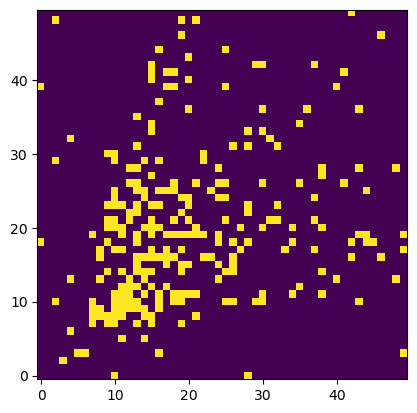

In [14]:
plt.imshow(param_dict['support'][:2500].reshape(50, 50))
plt.gca().invert_yaxis()

In [15]:
X_train = pd.DataFrame(X[train_ids][:, param_dict['support']])
Y_train = pd.DataFrame(Y[train_ids])
X_test = pd.DataFrame(X[test_ids][:, param_dict['support']])
Y_test = pd.DataFrame(Y[test_ids])
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2501, 250), (1312, 250), (2501, 1), (1312, 1))

In [16]:
X_full = pd.DataFrame(X[:, param_dict['support']])
Y_full = pd.DataFrame(Y)
X_full.shape, Y_full.shape

((3813, 250), (3813, 1))

In [17]:
_idx = np.random.permutation(len(X_full))
_x, _y = X_full.iloc[_idx], Y_full.iloc[_idx]
print(_x.shape, _y.shape)
data_dmatrix = xgb.DMatrix(data=_x, label=_y)

(3813, 250) (3813, 1)


In [18]:
params = {"objective":"reg:squarederror", 'tree_method': 'gpu_hist',
          'colsample_bytree': 1,'learning_rate': 0.1, 
           'subsample': 1, 'max_depth': 5, 'gamma': 0.00,
          'reg_alpha': 0.00, 'reg_lambda': 0, 'min_split_loss': 0.0, 'min_child_weight': 0, 'scale_pos_weight': 0}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True, seed=123)

In [19]:
xgb_cv.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
491,0.145355,0.006703,0.188852,0.009541,4.114772,0.065851,6.097199,0.050436
492,0.144445,0.006578,0.187755,0.009408,4.114690,0.065914,6.096995,0.050454
493,0.143652,0.006430,0.186787,0.009144,4.114535,0.065930,6.096866,0.050512
494,0.142788,0.006466,0.185577,0.009278,4.114447,0.065961,6.096824,0.050548
495,0.141924,0.006416,0.184444,0.009232,4.114270,0.065991,6.096783,0.050452


In [20]:
model = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params).fit(X_train, Y_train)

pred_vals_train_full = model.predict(X_train)
pred_vals_test_full = model.predict(X_test)

print(r2_score(Y_train.values, pred_vals_train_full))
print(r2_score(Y_test.values, pred_vals_test_full))
print("===")

0.9999593784336805
0.6698606395567579
===


In [21]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_train_pred = []
all_train_true = []
all_test_pred = []
all_test_true = []
all_models = []
train_used = 0

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    
    model = xgb.XGBRegressor(n_estimators=len(xgb_cv), **params).fit(x_train, y_train)
    all_models.append(model)
    pred_vals_train = model.predict(x_train)
    pred_vals_test = model.predict(x_test)
    
    all_train_pred.extend(pred_vals_train)
    all_test_pred.extend(pred_vals_test)
    all_train_true.extend(y_train.values)
    all_test_true.extend(y_test.values)
    
    print(f"({i}) TR : {np.sqrt(mean_squared_error(np.array(y_train), np.array(pred_vals_train))):.2f} - \
          TE : {np.sqrt(mean_squared_error(np.array(y_test), np.array(pred_vals_test))):.2f} \
          R2 : {r2_score(y_test.values, pred_vals_test):.2f}")

(0) TR : 0.08 -           TE : 6.29           R2 : 0.88
(1) TR : 0.09 -           TE : 6.13           R2 : 0.89
(2) TR : 0.09 -           TE : 6.06           R2 : 0.89
(3) TR : 0.09 -           TE : 6.97           R2 : 0.86
(4) TR : 0.08 -           TE : 5.86           R2 : 0.90
(5) TR : 0.08 -           TE : 6.90           R2 : 0.85
(6) TR : 0.09 -           TE : 5.56           R2 : 0.91
(7) TR : 0.08 -           TE : 5.69           R2 : 0.90
(8) TR : 0.08 -           TE : 5.58           R2 : 0.91
(9) TR : 0.08 -           TE : 5.82           R2 : 0.90


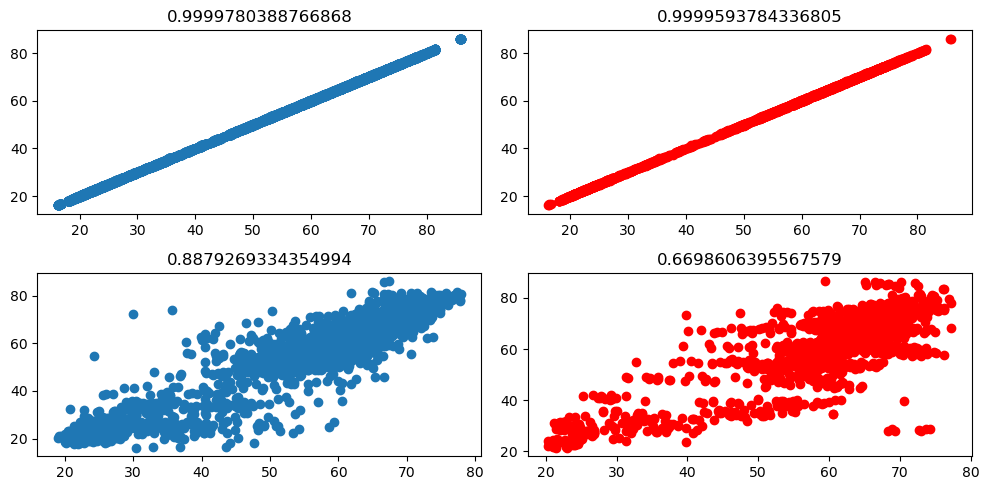

In [22]:
fig, ax = plt.subplots(2,2,figsize=(10, 5))
all_train_pred = np.array(all_train_pred)
all_train_true = np.array(all_train_true)
all_test_pred = np.array(all_test_pred)
all_test_true = np.array(all_test_true)


ax[0][0].scatter(all_train_pred, all_train_true)
ax[0][0].set_title(r2_score(all_train_true, all_train_pred))

ax[1][0].scatter(all_test_pred, all_test_true)
ax[1][0].set_title(r2_score(all_test_true, all_test_pred))

ax[0][1].scatter(pred_vals_train_full, Y_train.values, color='r')
ax[0][1].set_title(r2_score(Y_train.values, pred_vals_train_full))

ax[1][1].scatter(pred_vals_test_full, Y_test.values, color='r')
ax[1][1].set_title(r2_score(Y_test.values, pred_vals_test_full))
plt.tight_layout()

# grid search

In [23]:
print(_x.shape, _y.shape)
n_estimators = len(xgb_cv)

(3813, 250) (3813, 1)


In [25]:
param_test1 = {
#  'max_depth':[2, 4, 6, 8], # 8
#  'min_child_weight': [2, 4, 6, 8] # 8
    'max_depth':[7, 8, 9],  # 8
    'min_child_weight': [7, 8, 9]  # 3
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n_estimators, max_depth=4,
 min_child_weight=0, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=0, seed=123), 
 param_grid = param_test1, scoring='r2', n_jobs=4, cv=10, verbose=1)
gsearch1.fit(_x, _y)
gsearch1.best_params_, gsearch1.best_score_

Fitting 10 folds for each of 9 candidates, totalling 90 fits


({'max_depth': 8, 'min_child_weight': 8}, 0.8824558704574473)

In [39]:
param_test2 = {
#     'gamma': [0, 0.1, 0.01, 0.001, 0.0001] # 0.1
#  'gamma': [i/10.0 for i in range(1,5)]
    'gamma': [0.05, 0.2, 0.4]
}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n_estimators, max_depth=8,
 min_child_weight=8, gamma=0, subsample=1, colsample_bytree=1,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=0, seed=123), 
 param_grid = param_test2, scoring='r2', n_jobs=4, cv=10, verbose=1)
gsearch2.fit(_x, _y)
gsearch2.best_params_, gsearch2.best_score_

Fitting 10 folds for each of 3 candidates, totalling 30 fits


({'gamma': 0.05}, 0.8816610074929747)

In [40]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6, 11)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n_estimators, max_depth=8,
 min_child_weight=8, gamma=0.05, subsample=1, colsample_bytree=1,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=0, seed=123), 
 param_grid = param_test3, scoring='r2', n_jobs=4, cv=10, verbose=1)
gsearch3.fit(_x, _y)
gsearch3.best_params_, gsearch3.best_score_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.8831909868608916)

In [41]:
param_test4 = {
 'reg_alpha': [0, 0.1, 0.05, 0.01, 0.005]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n_estimators, max_depth=8,
 min_child_weight=8, gamma=0.05, subsample=0.9, colsample_bytree=0.6,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=0, seed=123), 
 param_grid = param_test4, scoring='r2', n_jobs=4, cv=10, verbose=1)
gsearch4.fit(_x, _y)
gsearch4.best_params_, gsearch4.best_score_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


({'reg_alpha': 0.1}, 0.8832825838766635)

In [42]:
param_test5 = {
 'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1] # 0.1
#   'reg_lambda': [0.05, 0.1, 0.5]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=n_estimators, max_depth=8,
 min_child_weight=8, gamma=0.05, subsample=0.9, colsample_bytree=0.6, reg_alpha=0.1,
 objective= 'reg:squarederror', tree_method='gpu_hist', scale_pos_weight=0, seed=123), 
 param_grid = param_test5, scoring='r2', n_jobs=4, cv=10, verbose=1)
gsearch5.fit(_x, _y)
gsearch5.best_params_, gsearch5.best_score_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


({'reg_lambda': 0.1}, 0.8833748172086542)

In [43]:
params = {"objective":"reg:squarederror", 'tree_method': 'gpu_hist',
          'colsample_bytree': 0.6,'learning_rate': 0.01, 
           'subsample': 0.9, 'max_depth': 8, 'gamma': 0.05,
          'reg_alpha': 0.01, 'reg_lambda': 0.1, 'min_split_loss': 0.0, 'min_child_weight': 8, 'scale_pos_weight': 0}

xgb_cv_post = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=5000, early_stopping_rounds=5, metrics=["mae", "rmse"], as_pandas=True, seed=123)

In [44]:
xgb_cv_post.tail(5)

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
3306,0.007504,0.001583,0.012865,0.002504,3.862033,0.081875,5.881140,0.104284
3307,0.007492,0.001580,0.012845,0.002499,3.862032,0.081874,5.881141,0.104284
3308,0.007481,0.001580,0.012829,0.002499,3.862032,0.081875,5.881141,0.104284
3309,0.007471,0.001582,0.012812,0.002502,3.862030,0.081875,5.881140,0.104284
3310,0.007461,0.001584,0.012796,0.002505,3.862029,0.081875,5.881139,0.104284


# PARAMS

In [45]:
n_estimators = len(xgb_cv_post)
param_dict['n_estimators'] = n_estimators
param_dict['params'] = params
pkl.dump(param_dict, open(f"./params/params_age_20d_v7.pkl", "wb"))

# Final tests

In [47]:
model_full = xgb.XGBRegressor(n_estimators=param_dict['n_estimators'], **param_dict['params']).fit(X_train, Y_train)

pred_vals_train_full = model_full.predict(X_train)
pred_vals_test_full = model_full.predict(X_test)

print(r2_score(Y_train.values, pred_vals_train_full))
print(r2_score(Y_test.values, pred_vals_test_full))
print("===")
dump(model_full, './models/model_full_age_20d_v7.joblib')

0.9999997472072555
0.6719642430328127
===


['./models/model_full_age_20d_v7.joblib']

In [48]:
model_full = load('./models/model_full_age_20d_v7.joblib')
pred_vals_train_full = model_full.predict(X_train)
pred_vals_test_full = model_full.predict(X_test)

print(r2_score(Y_train.values, pred_vals_train_full))
print(r2_score(Y_test.values, pred_vals_test_full))
print("===")

0.9999997472072555
0.6719642430328127
===


In [49]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
all_train_pred = []
all_train_true = []
all_test_pred = []
all_test_true = []
all_models = []
train_used = 0

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    
    model = xgb.XGBRegressor(n_estimators=param_dict['n_estimators'], **param_dict['params']).fit(x_train, y_train)
    all_models.append(model)
    pred_vals_train = model.predict(x_train)
    pred_vals_test = model.predict(x_test)
    
    all_train_pred.extend(pred_vals_train)
    all_test_pred.extend(pred_vals_test)
    all_train_true.extend(y_train.values)
    all_test_true.extend(y_test.values)
    
    print(f"({i}) TR : {np.sqrt(mean_squared_error(np.array(y_train), np.array(pred_vals_train))):.2f} - \
          TE : {np.sqrt(mean_squared_error(np.array(y_test), np.array(pred_vals_test))):.2f} \
          R2 : {r2_score(y_test.values, pred_vals_test):.2f}")

(0) TR : 0.01 -           TE : 6.14           R2 : 0.88
(1) TR : 0.01 -           TE : 5.81           R2 : 0.90
(2) TR : 0.01 -           TE : 5.87           R2 : 0.90
(3) TR : 0.01 -           TE : 6.79           R2 : 0.86
(4) TR : 0.01 -           TE : 5.39           R2 : 0.91
(5) TR : 0.01 -           TE : 6.04           R2 : 0.89
(6) TR : 0.01 -           TE : 5.22           R2 : 0.92
(7) TR : 0.01 -           TE : 5.67           R2 : 0.90
(8) TR : 0.01 -           TE : 5.49           R2 : 0.91
(9) TR : 0.01 -           TE : 5.79           R2 : 0.90


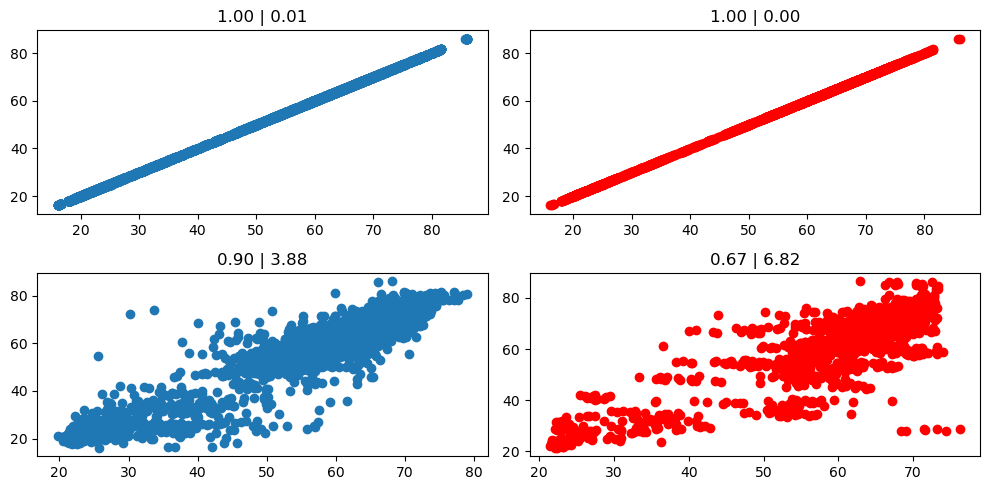

In [50]:
fig, ax = plt.subplots(2,2,figsize=(10, 5))
all_train_pred = np.array(all_train_pred)
all_train_true = np.array(all_train_true)
all_test_pred = np.array(all_test_pred)
all_test_true = np.array(all_test_true)


ax[0][0].scatter(all_train_pred, all_train_true)
ax[0][0].set_title(f"{r2_score(all_train_true, all_train_pred):.2f} | {mean_absolute_error(all_train_true, all_train_pred):.2f}")

ax[1][0].scatter(all_test_pred, all_test_true)
ax[1][0].set_title(f"{r2_score(all_test_true, all_test_pred):.2f} | {mean_absolute_error(all_test_true, all_test_pred):.2f}")

ax[0][1].scatter(pred_vals_train_full, Y_train.values, color='r')
ax[0][1].set_title(f"{r2_score(Y_train.values, pred_vals_train_full):.2f} | {mean_absolute_error(Y_train.values, pred_vals_train_full):.2f}")

ax[1][1].scatter(pred_vals_test_full, Y_test.values, color='r')
ax[1][1].set_title(f"{r2_score(Y_test.values, pred_vals_test_full):.2f} | {mean_absolute_error(Y_test.values, pred_vals_test_full):.2f}")
plt.tight_layout()

# Time-effect

In [51]:
results_dict = {}
results_dict[20] = {
    'all_train_pred': all_train_pred,
    'all_train_true': all_train_true,
    'all_test_pred': all_test_pred,
    'all_test_true': all_test_true,
    'pred_vals_train_full': pred_vals_train_full,
    'true_vals_train_full': Y_train.values,
    'pred_vals_test_full': pred_vals_test_full,
    'true_vals_test_full': Y_test.values,
    }

In [52]:
for win in [1, 2, 3, 7]:
    data = loadmat(f'./age_model_1_data_{win}_v7.mat')
    X_sp = np.squeeze(data['X_all'])
    a_sp = np.squeeze(data['y_all'])
    g_sp = np.squeeze(data['g_all'])
    u_sp = np.squeeze(data['u_all'])
    e_sp = np.squeeze(data['e_all'])
    d_sp = np.squeeze(data['d_all'])
    n_sp = np.squeeze(data['n_all'])
    s_sp = np.squeeze(data['s_all'])
    p_sp = np.squeeze(data['p_all'])
    td_sp = np.squeeze(data['td_all'])
    p_sp = np.array([a[0] for a in p_sp])

    # filter not full days
    X_sp = X_sp[d_sp == win]
    a_sp = a_sp[d_sp == win]
    g_sp = g_sp[d_sp == win]
    u_sp = u_sp[d_sp == win]
    e_sp = e_sp[d_sp == win]
    n_sp = n_sp[d_sp == win]
    s_sp = s_sp[d_sp == win]
    p_sp = p_sp[d_sp == win]
    td_sp = td_sp[d_sp == win]
    d_sp = d_sp[d_sp == win]
    
    train_ids = []
    test_ids = []

    dict_pi = {}
    for i, (_p, _d, _a) in enumerate(zip(p_sp, td_sp, a_sp)):
        if _p not in dict_pi:
            dict_pi[_p] = [1, _d, [i], _a]
        else:
            dict_pi[_p][0] += 1 
            dict_pi[_p][2].append(i) 

    test_dict = {}
    train_dict = {}

    for k, v in dict_pi.items():
        if v[1] >= 490:
            test_dict[k] = v
        else:
            train_dict[k] = v   

    print(f"Train: people = {len(train_dict)} | tests = {sum([v[0] for k,v in train_dict.items()])}")
    print(f"Test: people = {len(test_dict)} | tests = {sum([v[0] for k,v in test_dict.items()])}")

    train_ids = []
    test_ids = []
    for k, v in train_dict.items():
        train_ids.extend(v[2])
    for k, v in test_dict.items():
        test_ids.extend(v[2])
    train_ids = np.array(train_ids)
    test_ids = np.array(test_ids)
    len(train_ids), len(test_ids)
    
    train_ids = np.array(train_ids)
    test_ids = np.array(test_ids)

    X = np.concatenate([X_sp, g_sp[:, None], np.log10(u_sp[:, None]), e_sp[:, None], s_sp[:, None]], axis=1)
    Y = a_sp
    X_train = pd.DataFrame(X[train_ids][:, param_dict['support']])
    Y_train = pd.DataFrame(Y[train_ids])
    X_test = pd.DataFrame(X[test_ids][:, param_dict['support']])
    Y_test = pd.DataFrame(Y[test_ids])
    X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
    
    model = xgb.XGBRegressor(n_estimators=param_dict['n_estimators'], **param_dict['params']).fit(X_train, Y_train)

    pred_vals_train_full = model.predict(X_train)
    pred_vals_test_full = model.predict(X_test)

    print(r2_score(Y_train.values, pred_vals_train_full))
    print(r2_score(Y_test.values, pred_vals_test_full))
    print("===")
    dump(model, f'./models/model_full_age_{win}d.joblib')
    
#     kf = KFold(n_splits=10, shuffle=True, random_state=42)
#     all_train_pred = []
#     all_train_true = []
#     all_test_pred = []
#     all_test_true = []
#     all_models = []
#     train_used = 0

#     for i, (train_index, test_index) in enumerate(kf.split(X_train)):
#         x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

#         model = xgb.XGBRegressor(n_estimators=param_dict['n_estimators'], **param_dict['params']).fit(x_train, y_train)
#         all_models.append(model)
#         pred_vals_train = model.predict(x_train)
#         pred_vals_test = model.predict(x_test)

#         all_train_pred.extend(pred_vals_train)
#         all_test_pred.extend(pred_vals_test)
#         all_train_true.extend(y_train.values)
#         all_test_true.extend(y_test.values)

#         print(f"({i}) TR : {np.sqrt(mean_squared_error(np.array(y_train), np.array(pred_vals_train))):.2f} - \
#               TE : {np.sqrt(mean_squared_error(np.array(y_test), np.array(pred_vals_test))):.2f} \
#               R2 : {r2_score(y_test.values, pred_vals_test):.2f}")
    
#     all_train_pred = np.array(all_train_pred)
#     all_train_true = np.array(all_train_true)
#     all_test_pred = np.array(all_test_pred)
#     all_test_true = np.array(all_test_true)
    
#     print("=" * 30)
    
#     results_dict[win] = {
#     'all_train_pred': all_train_pred,
#     'all_train_true': all_train_true,
#     'all_test_pred': all_test_pred,
#     'all_test_true': all_test_true,
#     'pred_vals_train_full': pred_vals_train_full,
#     'true_vals_train_full': Y_train.values,
#     'pred_vals_test_full': pred_vals_test_full,
#     'true_vals_test_full': Y_test.values,
#     }

Train: people = 550 | tests = 1380
Test: people = 228 | tests = 2450


KeyboardInterrupt: 

### Execute with saved models

In [ ]:
for win in [1, 2, 3, 7, 20]:
    data = loadmat(f'./age_model_1_data_{win}_v5.mat')
    X_sp = np.squeeze(data['X_all'])
    a_sp = np.squeeze(data['y_all'])
    g_sp = np.squeeze(data['g_all'])
    u_sp = np.squeeze(data['u_all'])
    e_sp = np.squeeze(data['e_all'])
    d_sp = np.squeeze(data['d_all'])
    n_sp = np.squeeze(data['n_all'])
    s_sp = np.squeeze(data['s_all'])
    p_sp = np.squeeze(data['p_all'])
    td_sp = np.squeeze(data['td_all'])
    p_sp = np.array([a[0] for a in p_sp])

    # filter not full days
    if win < 20:
        X_sp = X_sp[d_sp == win]
        a_sp = a_sp[d_sp == win]
        g_sp = g_sp[d_sp == win]
        u_sp = u_sp[d_sp == win]
        e_sp = e_sp[d_sp == win]
        n_sp = n_sp[d_sp == win]
        s_sp = s_sp[d_sp == win]
        p_sp = p_sp[d_sp == win]
        td_sp = td_sp[d_sp == win]
        d_sp = d_sp[d_sp == win]
    
    train_ids = []
    test_ids = []

    dict_pi = {}
    for i, (_p, _d, _a) in enumerate(zip(p_sp, td_sp, a_sp)):
        if _p not in dict_pi:
            dict_pi[_p] = [1, _d, [i], _a]
        else:
            dict_pi[_p][0] += 1 
            dict_pi[_p][2].append(i) 

    test_dict = {}
    train_dict = {}

    for k, v in dict_pi.items():
        if v[1] >= 490:
            test_dict[k] = v
        else:
            train_dict[k] = v   

    print(f"Train: people = {len(train_dict)} | tests = {sum([v[0] for k,v in train_dict.items()])}")
    print(f"Test: people = {len(test_dict)} | tests = {sum([v[0] for k,v in test_dict.items()])}")

    train_ids = []
    test_ids = []
    for k, v in train_dict.items():
        train_ids.extend(v[2])
    for k, v in test_dict.items():
        test_ids.extend(v[2])
    train_ids = np.array(train_ids)
    test_ids = np.array(test_ids)
    len(train_ids), len(test_ids)
    
    train_ids = np.array(train_ids)
    test_ids = np.array(test_ids)

    X = np.concatenate([X_sp, g_sp[:, None], np.log10(u_sp[:, None]), e_sp[:, None], s_sp[:, None]], axis=1)
    Y = a_sp
    X_train = pd.DataFrame(X[train_ids][:, param_dict['support']])
    Y_train = pd.DataFrame(Y[train_ids])
    X_test = pd.DataFrame(X[test_ids][:, param_dict['support']])
    Y_test = pd.DataFrame(Y[test_ids])
    X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
    
    model = load(f'./models/model_full_age_{win}d.joblib')

    pred_vals_train_full = model.predict(X_train)
    pred_vals_test_full = model.predict(X_test)

    print(r2_score(Y_train.values, pred_vals_train_full))
    print(r2_score(Y_test.values, pred_vals_test_full))
    print("===")
#     dump(model, f'./models/model_full_age_{win}d.joblib')
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    all_train_pred = []
    all_train_true = []
    all_test_pred = []
    all_test_true = []
    all_models = []
    train_used = 0

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        model = xgb.XGBRegressor(n_estimators=param_dict['n_estimators'], **param_dict['params']).fit(x_train, y_train)
        all_models.append(model)
        pred_vals_train = model.predict(x_train)
        pred_vals_test = model.predict(x_test)

        all_train_pred.extend(pred_vals_train)
        all_test_pred.extend(pred_vals_test)
        all_train_true.extend(y_train.values)
        all_test_true.extend(y_test.values)

        print(f"({i}) TR : {np.sqrt(mean_squared_error(np.array(y_train), np.array(pred_vals_train))):.2f} - \
              TE : {np.sqrt(mean_squared_error(np.array(y_test), np.array(pred_vals_test))):.2f} \
              R2 : {r2_score(y_test.values, pred_vals_test):.2f}")
    
    all_train_pred = np.array(all_train_pred)
    all_train_true = np.array(all_train_true)
    all_test_pred = np.array(all_test_pred)
    all_test_true = np.array(all_test_true)
    
    print("=" * 30)
    
    results_dict[win] = {
    'all_train_pred': all_train_pred,
    'all_train_true': all_train_true,
    'all_test_pred': all_test_pred,
    'all_test_true': all_test_true,
    'pred_vals_train_full': pred_vals_train_full,
    'true_vals_train_full': Y_train.values,
    'pred_vals_test_full': pred_vals_test_full,
    'true_vals_test_full': Y_test.values,
    }

## Plot it 

In [ ]:
import pickle as pkl
pkl.dump(results_dict, open('results_daywise_age_prediction.pkl', 'wb'))

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(20, 10))
train_int = []
test_int = []
train_full = []
test_full = []
labels_train_int = []
labels_test_int = []
labels_train_full = []
labels_test_full = []
for w in [1, 2, 3, 7, 20]:
    _d = results_dict[w]
    train_int.extend(np.abs(np.squeeze(_d['all_train_true']) - np.squeeze(_d['all_train_pred'])))
    test_int.extend(np.abs(np.squeeze(_d['all_test_true']) - np.squeeze(_d['all_test_pred'])))
    train_full.extend(np.abs(np.squeeze(_d['true_vals_train_full']) - np.squeeze(_d['pred_vals_train_full'])))
    test_full.extend(np.abs(np.squeeze(_d['true_vals_test_full']) - np.squeeze(_d['pred_vals_test_full'])))
    labels_train_int.extend([w] * len(_d['all_train_true']))
    labels_test_int.extend([w] * len(_d['all_test_true']))
    labels_train_full.extend([w] * len(_d['true_vals_train_full']))
    labels_test_full.extend([w] * len(_d['true_vals_test_full']))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

a = pd.DataFrame.from_dict({'labels':labels_train_int, 'vals': train_int})
sns.stripplot(data=a, x='labels', y='vals', ax=ax[0][0]) # train int 
ax[0][0].set_title("train int")

a = pd.DataFrame.from_dict({'labels':labels_train_full, 'vals': train_full})
sns.stripplot(data=a, x='labels', y='vals', ax=ax[0][1]) # train full 
ax[0][1].set_title("train full")

a = pd.DataFrame.from_dict({'labels':labels_test_int, 'vals': test_int})
sns.stripplot(data=a, x='labels', y='vals', ax=ax[1][0]) # test int
ax[1][0].set_title("test int")

for i, w in enumerate([1,2,3,7,20]):
    _mae = a[a['labels'] == w].vals.mean()
    ax[1][0].plot([i - 0.2, i + 0.2], [_mae, _mae], linewidth=5)
ax[1][0].set_ylabel('MAE')
ax[1][0].set_xticklabels(["1","2","3","7","20"])
ax[1][0].set_xlabel("JID accumulation (days)") 
ax[1][0].set_ylim([-1, 20])
a = pd.DataFrame.from_dict({'labels':labels_test_full, 'vals': test_full})
sns.stripplot(data=a, x='labels', y='vals', ax=ax[1][1]) # test full
ax[1][1].set_title("test full")
for i, w in enumerate([1,2,3,7,20]):
    _mae = a[a['labels'] == w].vals.mean()
    ax[1][1].plot([i - 0.2, i + 0.2], [_mae, _mae], linewidth=5)
ax[1][1].set_ylabel('MAE')
ax[1][1].set_xticklabels(["1","2","3","7","20"])
ax[1][1].set_xlabel("JID accumulation (days)")
ax[1][1].set_ylim([-1, 20])
plt.savefig('./figures/full_age_unseen_1d_20d_comparison.pdf')

# Trajectories

## age model trajectories 20d

In [19]:
data = loadmat(f'./data/rtime_20d_pre_v4.mat')
v_sp = np.squeeze(data['v_all'])
p2_sp = np.squeeze(data['p_all'])
times_sp = np.squeeze(data['times'])
p2_sp = np.array([a[0] for a in p2_sp])

In [ ]:
data = loadmat(f'./age_model_1_data_20_v5.mat')

a_sp = np.squeeze(data['y_all'])
p_sp = np.squeeze(data['p_all'])
td_sp = np.squeeze(data['td_all'])
p_sp = np.array([a[0] for a in p_sp])

train_ids = []
test_ids = []

dict_pi = {}
for i, (_p, _d, _a) in enumerate(zip(p_sp, td_sp, a_sp)):
    if _p not in dict_pi:
        dict_pi[_p] = [1, _d, [i], _a]
    else:
        dict_pi[_p][0] += 1 
        dict_pi[_p][2].append(i) 

test_dict = {}
train_dict = {}

for k, v in dict_pi.items():
    if v[1] >= 490:
        test_dict[k] = v
    else:
        train_dict[k] = v   

print(f"Train: people = {len(train_dict)} | tests = {sum([v[0] for k,v in train_dict.items()])}")
print(f"Test: people = {len(test_dict)} | tests = {sum([v[0] for k,v in test_dict.items()])}")

train_ids = []
test_ids = []
for k, v in train_dict.items():
    train_ids.extend(v[2])
for k, v in test_dict.items():
    test_ids.extend(v[2])
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)
len(train_ids), len(test_ids)

train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

In [20]:
param_dict = pkl.load(open(f"./params/params_age_20d.pkl", "rb"))

In [164]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
model_full = load('./models/model_full_age_20d.joblib')
for i, name in notebook.tqdm(enumerate(os.listdir(f"./evolution_v2_20d_24s/"))):
    
    data = loadmat(f"./evolution_v2_20d_24s/{name}")
    X_ = np.squeeze(data['x']).T
    a_ = np.squeeze(data['all_ages'])
    u_ = np.squeeze(data['all_med_usage'])
    g_ = np.squeeze(data['gender'])
    e_ = np.squeeze(data['all_entropy'])
    t_ = np.squeeze(data['all_ts'])
    nd_ = np.squeeze(data['all_n_days'])
    s_ = np.squeeze(data['phoneModel'])
    pid = data['partId'][0]

    idxs = find_longest_uninterrupted(t_)
    if idxs is None:
        continue
    
    X_ = X_[idxs[0]:idxs[1] + 1]
    a_ = a_[idxs[0]:idxs[1] + 1]
    u_ = u_[idxs[0]:idxs[1] + 1]
    e_ = e_[idxs[0]:idxs[1] + 1]
    t_ = t_[idxs[0]:idxs[1] + 1]
    nd_ = nd_[idxs[0]:idxs[1] + 1]
    
    
        
    t_t = np.concatenate([v_sp[p2_sp == pid], times_sp[p2_sp == pid][:, None]], axis=1)
    
        
    X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None]), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
    X = pd.DataFrame(X[:, param_dict['support']])

    pred_over_time = model_full.predict(X)
    pred_over_time[t_ < 1] = np.nan
    if len(pred_over_time[~np.isnan(pred_over_time)]) / len(pred_over_time) * 100 < 50:
        continue
    if name.split('.')[0] in list(test_dict.keys()):
        was_testing.append(1)
    else:
        was_testing.append(0)
    all_tests_with_times.append(t_t)
    all_preds_times.append(t_)
#     pred_over_time_w_time = np.array([pred_over_time, t_])
    all_preds.append(pred_over_time)
    all_entropy.append(entropy(np.histogram(pred_over_time, bins=np.linspace(16, 85, 100), density=True)[0]))
    all_ages.append(a_[a_ > 0][-1])
    all_genders.append(float(g_))
    the_gap.append(a_[a_ > 0][-1] - np.median(pred_over_time))
    all_pids.append(pid)

0it [00:00, ?it/s]

/tmp/ipykernel_223046/2148908412.py:40: RuntimeWarning: divide by zero encountered in log10
  X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None]), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)


In [152]:
for i, g in enumerate(all_preds_times):
    if len(g) == 578:
        print(f"{i} | {len(g)}")

209 | 578


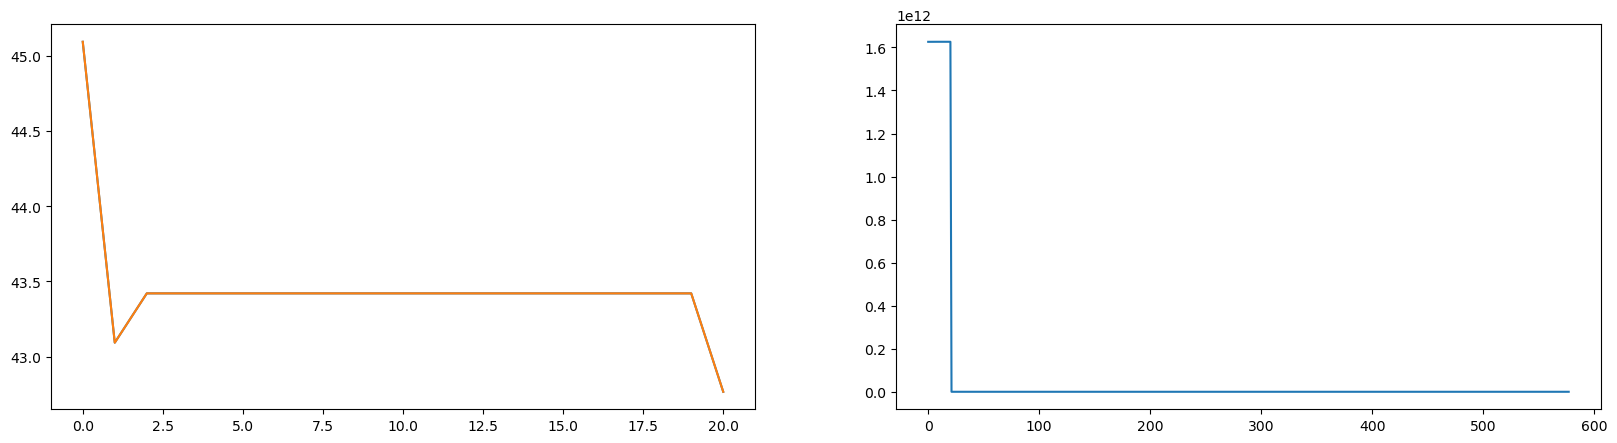

In [154]:
IDx = 209
ff = np.where(all_preds_times[IDx] == 0)[0]
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].plot(all_preds[IDx])
idxs = find_longest_uninterrupted(all_preds_times[IDx])
if idxs:
    ax[0].plot(all_preds[IDx][idxs[0]:idxs[1] + 1])
ax[1].plot(all_preds_times[IDx]);

In [139]:
def find_longest_uninterrupted(times):
    beg_int = np.where(np.diff(np.float32(times < 1)) == 1)[0] + 1
    end_int = np.where(np.diff(np.float32(times < 1)) == -1)[0] + 1
    _int_len = [ e - b for b, e in zip(beg_int, end_int) if e - b > 7]
#     print(_int_len)
    _int = [(b, e) for b, e in zip(beg_int, end_int) if e - b > 7]
    non_int = [0] + list(itertools.chain.from_iterable(_int)) + [len(times) - 1]
    _non_int = [(a, b) for a, b in zip(non_int[::2], non_int[1::2])]
    _non_int_len = [a[1] - a[0] for a in _non_int]
#     print(_non_int_len)
    longest = np.argmax(_non_int_len)
    
    if np.max(_non_int_len) >= 365:
        return _non_int[longest]
    else:
        return None

In [165]:
len(was_testing)

265

In [166]:
savemat('./for_landscapes/all_pred_seen_and_unseen_with_crt_20d_25_04_2023.mat', {'all_preds': all_preds, 
                                                  'all_preds_times': all_preds_times,
                                                  'all_ages': all_ages, 
                                                  'all_genders': all_genders, 
                                                  'all_pids': all_pids, 
                                                  'was_testing': was_testing,
                                                  'tests_with_time': all_tests_with_times})

/home/enea/anaconda3/envs/trash2/lib/python3.8/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


## age model trajectories 7d

In [ ]:
data = loadmat(f'./data/rtime_7d_pre_v4.mat')
v_sp = np.squeeze(data['v_all'])
p2_sp = np.squeeze(data['p_all'])
times_sp = np.squeeze(data['times'])
p2_sp = np.array([a[0] for a in p2_sp])

In [ ]:
data = loadmat(f'./age_model_1_data_7_v5.mat')

a_sp = np.squeeze(data['y_all'])
p_sp = np.squeeze(data['p_all'])
td_sp = np.squeeze(data['td_all'])
p_sp = np.array([a[0] for a in p_sp])

train_ids = []
test_ids = []

dict_pi = {}
for i, (_p, _d, _a) in enumerate(zip(p_sp, td_sp, a_sp)):
    if _p not in dict_pi:
        dict_pi[_p] = [1, _d, [i], _a]
    else:
        dict_pi[_p][0] += 1 
        dict_pi[_p][2].append(i) 

test_dict = {}
train_dict = {}

for k, v in dict_pi.items():
    if v[1] >= 490:
        test_dict[k] = v
    else:
        train_dict[k] = v   

print(f"Train: people = {len(train_dict)} | tests = {sum([v[0] for k,v in train_dict.items()])}")
print(f"Test: people = {len(test_dict)} | tests = {sum([v[0] for k,v in test_dict.items()])}")

train_ids = []
test_ids = []
for k, v in train_dict.items():
    train_ids.extend(v[2])
for k, v in test_dict.items():
    test_ids.extend(v[2])
train_ids = np.array(train_ids)
test_ids = np.array(test_ids)
len(train_ids), len(test_ids)

train_ids = np.array(train_ids)
test_ids = np.array(test_ids)

In [ ]:
all_ages = []
all_genders = []
all_entropy = []
the_gap = []
all_preds = []
all_preds_times = []
all_pids = []
was_testing = []
all_tests_with_times = []
model_full = load('./models/model_full_age_7d.joblib')
for i, name in notebook.tqdm(enumerate(os.listdir(f"./evolution_7d/"))):
    
    data = loadmat(f"./evolution_7d/{name}")
    X_ = np.squeeze(data['x']).T
    a_ = np.squeeze(data['all_ages'])
    u_ = np.squeeze(data['all_med_usage'])
    g_ = np.squeeze(data['gender'])
    e_ = np.squeeze(data['all_entropy'])
    t_ = np.squeeze(data['all_ts'])
    nd_ = np.squeeze(data['all_n_days'])
    s_ = np.squeeze(data['phoneModel'])
    pid = data['partId'][0]
#     if len(t_[t_ < 1]) > 0:
#         print("Has blanks skipping ...")
#         continue
    __a = a_[-1]
    for __a in a_[::-1]:
        if __a != 0:
            all_ages.append(__a)
            break
    if __a == 0:
        continue
    if len(t_) < 1:
        continue
    if name.split('.')[0] in list(test_dict.keys()):
        was_testing.append(1)
    else:
        was_testing.append(0)
        
    t_t = np.concatenate([v_sp[p2_sp == pid], times_sp[p2_sp == pid][:, None]], axis=1)
    all_tests_with_times.append(t_t)
        
    X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None]), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
    X = pd.DataFrame(X[:, param_dict['support']])

    pred_over_time = model_full.predict(X)
    all_preds_times.append(t_)
#     pred_over_time_w_time = np.array([pred_over_time, t_])
    all_preds.append(pred_over_time)
    all_entropy.append(entropy(np.histogram(pred_over_time, bins=np.linspace(16, 85, 100), density=True)[0]))
    
    all_genders.append(float(g_))
    the_gap.append(a_[-1] - np.median(pred_over_time))
    all_pids.append(pid)

In [ ]:
len(all_ages), len(all_preds)

In [ ]:
savemat('./for_landscapes/all_pred_seen_and_unseen_with_crt_7d.mat', {'all_preds': all_preds, 
                                                  'all_preds_times': all_preds_times,
                                                  'all_ages': all_ages, 
                                                  'all_genders': all_genders, 
                                                  'all_pids': all_pids, 
                                                  'was_testing': was_testing,
                                                  'tests_with_time': all_tests_with_times})

# EPI trajectories

In [ ]:
for N_DAYS in ['1d', '3d', '7d', '20d']:
    this_model = load(f'./models/model_full_age_{N_DAYS}.joblib')
    predictions = []
    pids = []

    for i, name in enumerate(os.listdir(f'./evol_epi/{N_DAYS}/')):

        data = loadmat(f"./evol_epi/{N_DAYS}/{name}")
        X_ = np.squeeze(data['x']).T
        a_ = np.squeeze(data['all_ages'])
        u_ = np.squeeze(data['all_med_usage'])
        g_ = np.squeeze(data['gender'])
        e_ = np.squeeze(data['all_entropy'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        s_ = np.squeeze(data['phoneModel'])
        pid = data['partId'][0]

        X_ = X_[t_ > 0]
        a_ = a_[t_ > 0]
        u_ = u_[t_ > 0]
        e_ = e_[t_ > 0]
        nd_ = nd_[t_ > 0]
        t_ = t_[t_ > 0]
        if len(t_) < 2:
            continue

        X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None] + 1e-15), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
        X = pd.DataFrame(X[:, param_dict['support']])

        pred_over_time = this_model.predict(X)
        predictions.append(np.array([t_, pred_over_time, a_]).T)
        pids.append(pid)
    savemat(f'./for_landscapes/epi/epi_predictions_age_{N_DAYS}.mat', {'pids': list(pids), 'predictions': predictions})

# Stroke trajectories

In [ ]:
for N_DAYS in ['1d', '3d', '7d', '20d']:
    this_model = load(f'./models/model_full_age_{N_DAYS}.joblib')
    predictions = []
    pids = []
    chrono_age = []

    for i, name in enumerate(os.listdir(f'./evol_stroke/{N_DAYS}/')):

        data = loadmat(f"./evol_stroke/{N_DAYS}/{name}")
        X_ = np.squeeze(data['x']).T
        a_ = np.squeeze(data['all_ages'])
        u_ = np.squeeze(data['all_med_usage'])
        g_ = np.squeeze(data['gender'])
        e_ = np.squeeze(data['all_entropy'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        s_ = np.squeeze(data['phoneModel'])
        pid = data['partId'][0]

        X_ = X_[t_ > 0]
        a_ = a_[t_ > 0]
        u_ = u_[t_ > 0]
        e_ = e_[t_ > 0]
        nd_ = nd_[t_ > 0]
        t_ = t_[t_ > 0]
        if len(t_) < 2:
            continue

        X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None] + 1e-15), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
        X = pd.DataFrame(X[:, param_dict['support']])

        pred_over_time = this_model.predict(X)
        predictions.append(np.array([t_, pred_over_time, a_, np.ones_like(a_) * g_]).T)
        pids.append(pid)
        chrono_age.append(np.nanmedian(a_[a_ > 0]))
    savemat(f'./for_landscapes/stroke/stroke_predictions_age_{N_DAYS}.mat', {'pids': list(pids), 'predictions': predictions, 'chrono_age': np.array(chrono_age)})

In [ ]:
healthy_data = loadmat('./for_landscapes/all_pred_seen_and_unseen_with_crt_7d.mat')
healthy_age = np.squeeze(healthy_data['all_ages'])
healthy_gender = np.squeeze(healthy_data['all_genders'])
healthy_data.keys()
healthy_pred = np.array([np.median(a) for a in np.squeeze(healthy_data['all_preds'])])
healthy_pred_gap = np.array([np.squeeze(a) - b for a, b in zip(np.squeeze(healthy_data['all_preds']), healthy_age)])
len(healthy_age), len(healthy_pred)

In [ ]:
stroke_data = loadmat('./for_landscapes/stroke/stroke_predictions_age_7d.mat')
stroke_age = np.squeeze(stroke_data['chrono_age'])
stroke_gender = np.array([a[0, -1] for a in np.squeeze(stroke_data['predictions'])])
stroke_pred = np.array([np.median(a[:, 1]) for a in np.squeeze(stroke_data['predictions'])])
stroke_pred_gap = np.array([a[:, 1] - b for a, b in zip(np.squeeze(stroke_data['predictions']), stroke_age)])
len(stroke_age), len(stroke_pred)
stroke_pred = stroke_pred[~np.isnan(stroke_age)]
stroke_gender = stroke_gender[~np.isnan(stroke_age)]
stroke_pred_gap = stroke_pred_gap[~np.isnan(stroke_age)]
stroke_age = stroke_age[~np.isnan(stroke_age)]
len(stroke_age), len(stroke_pred)

## Check gap with stroke

In [ ]:
# subsample based on stroke distribution
nboot = 3
subsets = []
subsets_gender = []

for _ in range(nboot):
    to_add_pred = []
    for x in np.int32(stroke_age):
        i = 0
        _gap_matched = healthy_pred_gap[np.int32(healthy_age) == x]
        _gap_matched_g = healthy_gender[np.int32(healthy_age) == x]
        while len(_gap_matched) == 0:  # if I don't have 83 I try with 84 anyway is close enough to match the distro
            i += 1
            _gap_matched = healthy_pred_gap[np.int32(healthy_age) == x + i]
            _gap_matched_g = healthy_gender[np.int32(healthy_age) == x + i]
        iii = np.random.choice(len(_gap_matched))
        subsets.append(_gap_matched[iii])
        subsets_gender.append(_gap_matched_g[iii])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))

idx = np.argsort(stroke_age)

ss = np.linspace(-0.0, 40, 41)

# ax[1].fill_between(ss, min_s_stroke[idx], max_s_stroke[idx], color='k', alpha=0.1, zorder=3)
# ax[1].scatter(np.arange(len(idx)), y_stroke_sub_test[idx], marker='o', color='blue', label='Chronological age')
# ax[1].scatter(np.arange(len(idx)), med_s_stroke[idx], marker='o', c='orange', label='Predicted age')
# ax[1].set_xlabel('Subject No. (Sorted by age)')
# ax[1].set_ylabel('Age [years]')
# # ax[1].plot([0, 40], [np.mean(ages), np.mean(ages)], 'k--', alpha=1.0, label='Mean age (healthy training set)')
# ax[1].plot([0, 40], [np.mean(all_pred_zeros), np.mean(all_pred_zeros)], 'r--', alpha=1.0, label='Default output')
# ax[1].fill_between(ss, np.percentile(all_pred_zeros, 2.5), np.percentile(all_pred_zeros, 97.5), color='r', alpha=0.1, zorder=3)

# handles, labels = ax[1].get_legend_handles_labels()
# order = [1, 2, 0]
# ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[0.0, 1.6])

# ax[1].grid(False)
# ax[1].spines['right'].set_visible(False)
# ax[1].spines['top'].set_visible(False)
# ax[1].set_ylim([18, 85])
# X = list(itertools.chain.from_iterable(stroke_pred_gap))
X = [np.median(a) for a in stroke_pred_gap]
# X = list(itertools.chain.from_iterable([a - y_stroke_sub_test for a in all_pred_stroke_ages]))
# ax[0].hist(X)
sns.kdeplot(X, ax=ax[0], bw_method=.4, linewidth=3, label='Stroke survivors', color='blue')
# Y = list(itertools.chain.from_iterable(subsets))
Y = [np.median(a) for a in subsets]
# Y = list(itertools.chain.from_iterable([a - b for a, b in zip(subsets_true, subsets_pred)]))
sns.kdeplot(Y, ax=ax[0], bw_method=.6, linewidth=3, label='Healthy population (age matched)', color='g')
# ax[0].hist(Y, color='g')

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend(shadow=False, fancybox=False, ncol=1, bbox_to_anchor=[.7, 1.6])
ax[0].set_xlabel("Error [years]")
ax[0].set_ylabel("Probability density")
ax[0].grid(False)
# ax[0].set_xlim([-10, 13])
# ax[0].set_ylim([0, 0.6])

plt.tight_layout()

# plt.savefig('./figures/v18/figure_2_panel_d_stroke.pdf')

In [ ]:
len(stroke_gender)

In [ ]:
median_age_gap_stroke = np.array([np.median(a) for a in stroke_pred_gap])
median_age_pred_stroke = np.array([np.median(a) for a in stroke_pred])
len(median_age_pred_stroke), len(median_age_gap_stroke)

savemat('median_predictions_age_stroke_healthy_age_matched_with_gender.mat', {
    "median_age_gap_stroke": median_age_gap_stroke,
    "gender_stroke": stroke_gender,
    "median_age_prediction_stroke": median_age_pred_stroke,
    "media_age_gap_healthy": [np.median(a) for a in subsets],
    "gender_healthy": subsets_gender
})

In [ ]:
plt.hist(median_age_gap_stroke)
plt.hist([np.median(a) for a in subsets])

In [ ]:
median_age_gap_stroke

In [ ]:
sns.kdeplot(median_age_gap_stroke, bw_method=.6, linewidth=3, label='Stroke survivors', color='blue')
sns.kdeplot([np.median(a) for a in subsets], bw_method=.6, linewidth=3, label='Stroke survivors', color='red')

## ARIMA fit comparisons

In [ ]:
stroke_data.keys()

In [ ]:
healthy_data = loadmat('./for_landscapes/all_pred_seen_and_unseen_with_crt_7d.mat')
healthy_age = np.squeeze(healthy_data['all_ages'])
healthy_gender = np.squeeze(healthy_data['all_genders'])
healthy_pred = np.squeeze(healthy_data['all_preds'])
healthy_pids = np.squeeze(healthy_data['all_pids'])
len(healthy_age), len(healthy_pred), len(healthy_pids)

In [ ]:
stroke_data = loadmat('./for_landscapes/stroke/stroke_predictions_age_7d.mat')
stroke_age = np.squeeze(stroke_data['chrono_age'])
stroke_gender = np.array([a[0, -1] for a in np.squeeze(stroke_data['predictions'])])
stroke_pred = np.squeeze(stroke_data['predictions'])
stroke_pids = np.squeeze(stroke_data['pids'])
stroke_pids = stroke_pids[~np.isnan(stroke_age)]
stroke_pred = stroke_pred[~np.isnan(stroke_age)]
stroke_gender = stroke_gender[~np.isnan(stroke_age)]
stroke_age = stroke_age[~np.isnan(stroke_age)]
len(stroke_age), len(stroke_pred), len(stroke_pids)

In [ ]:
# subsample based on stroke distribution
nboot = 3
subsets_idx = []
for _ in range(nboot):
    to_add_pred = []
    for x in np.int32(stroke_age):
        i = 0
        _gap_matched = np.where(np.int32(healthy_age) == x)[0]
        while len(_gap_matched) == 0:  # if I don't have 83 I try with 84 anyway is close enough to match the distro
            i += 1
            _gap_matched = np.where(np.int32(healthy_age) == x + i)[0]
        subsets_idx.append(np.random.choice(_gap_matched))

In [ ]:
healthy_matched_age = healthy_age[subsets_idx]
healthy_matched_gender = healthy_gender[subsets_idx]
healthy_matched_pred = healthy_pred[subsets_idx]
healthy_matched_pred_gap = healthy_pred_gap[subsets_idx]
healthy_matched_median_pred = np.array([np.median(a) for a in healthy_matched_pred])
healthy_matched_median_pred_gap = np.array([np.median(a) for a in healthy_matched_pred_gap])
healthy_matched_pids = healthy_pids[subsets_idx]

In [ ]:
aic_stroke = {(1,0,0): [], (0,1,0): [], (0,0,1): [], (1,1,0): [], (1,1,1): [], (1,1,2): []}
for p in stroke_pred:
    for order in list(aic.keys()):
        res = sm.tsa.arima.ARIMA(np.squeeze(p[:, 1]), order=order).fit()
        aic[order].append(res.aic)

In [ ]:
aic_healthy = {(1,0,0): [], (0,1,0): [], (0,0,1): [], (1,1,0): [], (1,1,1): [], (1,1,2): []}
for p in healthy_matched_pred:
    for order in list(aic.keys()):
        res = sm.tsa.arima.ARIMA(np.squeeze(p), order=order).fit()
        if res.aic != np.nan:
            aic_healthy[order].append(res.aic)

In [ ]:
sns.violinplot(pd.DataFrame(aic_healthy))
pd.DataFrame(aic_healthy).median()

In [ ]:
sns.violinplot(pd.DataFrame(aic))
pd.DataFrame(aic).median()

In [ ]:
order = (1, 1, 1)
healthy_params = np.array([sm.tsa.arima.ARIMA(np.squeeze(p)[:90], order=order, trend='t').fit(return_params=True) for p in subsets])
print(healthy_params.shape)
stroke_params = np.array([sm.tsa.arima.ARIMA(np.squeeze(p[:90, 1]), order=order, trend='t').fit(return_params=True) for p in stroke_pred])
print(stroke_params.shape)

In [ ]:
stroke_params_df = pd.DataFrame(np.concatenate([
    stroke_params, 
    stroke_age[:, None],
    median_age_pred_stroke[:, None],
    median_age_gap_stroke[:, None],
    stroke_pids[:, None],
    stroke_gender[:, None]
], axis=1), columns=['trend/drift', 'ar', 'ma', 'sigma2', 'chrono_age', 'median_pred_age', 'age_gap', 'pid', 'gender'])
stroke_params_df.to_csv('stroke_age_ARIMA_paramaters.csv', index=False)

In [ ]:
healthy_params_df = pd.DataFrame(np.concatenate([
    healthy_params, 
    healthy_matched_age[:, None],
    healthy_matched_median_pred[:, None],
    healthy_matched_median_pred_gap[:, None],
    healthy_matched_pids[:, None],
    healthy_matched_gender[:, None]
], axis=1), columns=['trend/drift', 'ar', 'ma', 'sigma2', 'chrono_age', 'median_pred_age', 'age_gap', 'pid', 'gender'])
healthy_params_df.to_csv('healthy_age_ARIMA_paramaters.csv', index=False)

In [ ]:
fig, ax = plt.subplots(2,stroke_params.shape[1], figsize=(20, 5))
vals = ['trend',
    'ar.L1',
'ma.L1',
'sigma2']
for i in range(stroke_params.shape[1]):
    sns.kdeplot(stroke_params[:, i], bw_method=.6, linewidth=3, label='Stroke survivors', color='blue', ax=ax[0][i])
    sns.kdeplot(healthy_params[:, i], bw_method=.6, linewidth=3, label='healthy', color='red', ax=ax[0][i])
    sns.ecdfplot(stroke_params[:, i], label='Stroke survivors', color='blue', ax=ax[1][i])
    sns.ecdfplot(healthy_params[:, i], label='healthy', color='red', ax=ax[1][i])
    ax[0][i].set_title(vals[i])
    ax[0][i].legend()
    ax[1][i].legend()

In [ ]:
both = PCA(3).fit_transform(np.concatenate([stroke_params, healthy_params]))
both.shape

In [ ]:
plt.scatter(both[:48, 2], both[:48, 1], c='blue', label='stroke')
plt.scatter(both[48:, 2], both[48:, 1], c='red', label='healthy')
plt.legend()

# RNS

In [ ]:
for N_DAYS in ['1d', '3d', '7d', '20d']:
    this_model = load(f'./models/model_full_age_{N_DAYS}.joblib')
    predictions = []
    pids = []

    for i, name in enumerate(os.listdir(f'./evol_rns/{N_DAYS}/')):

        data = loadmat(f"./evol_rns/{N_DAYS}/{name}")
        X_ = np.squeeze(data['x']).T
        a_ = np.squeeze(data['all_ages'])
        u_ = np.squeeze(data['all_med_usage'])
        g_ = np.squeeze(data['gender'])
        e_ = np.squeeze(data['all_entropy'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        s_ = np.squeeze(data['phoneModel'])
        pid = data['partId'][0]

        X_ = X_[t_ > 0]
        a_ = a_[t_ > 0]
        u_ = u_[t_ > 0]
        e_ = e_[t_ > 0]
        nd_ = nd_[t_ > 0]
        t_ = t_[t_ > 0]
        if len(t_) < 2:
            print(f"problem {name} {N_DAYS}")
            continue

        X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None] + 1e-15), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
        X = pd.DataFrame(X[:, param_dict['support']])

        pred_over_time = this_model.predict(X)
        predictions.append(np.array([t_, pred_over_time, a_, np.ones_like(a_) * g_]).T)
        pids.append(pid)
    savemat(f'./for_landscapes/rns/RNS_predictions_age_{N_DAYS}.mat', {'pids': list(pids), 'predictions': predictions})

In [ ]:
for N_DAYS in ['1d', '3d', '7d', '20d']:
    this_model = load(f'./models/model_full_age_{N_DAYS}.joblib')
    predictions = []
    pids = []

    for i, name in enumerate(os.listdir(f'./evol_brains/{N_DAYS}/')):

        data = loadmat(f"./evol_brains/{N_DAYS}/{name}")
        X_ = np.squeeze(data['x']).T
        a_ = np.squeeze(data['all_ages'])
        u_ = np.squeeze(data['all_med_usage'])
        g_ = np.squeeze(data['gender'])
        e_ = np.squeeze(data['all_entropy'])
        t_ = np.squeeze(data['all_ts'])
        nd_ = np.squeeze(data['all_n_days'])
        s_ = np.squeeze(data['phoneModel'])
        pid = data['partId'][0]

        X_ = X_[t_ > 0]
        a_ = a_[t_ > 0]
        u_ = u_[t_ > 0]
        e_ = e_[t_ > 0]
        nd_ = nd_[t_ > 0]
        t_ = t_[t_ > 0]
        if len(t_) < 2:
            print(f"problem {name} {N_DAYS}")
            continue

        X = np.concatenate([X_, np.ones_like(u_[:, None]) * g_, np.log10(u_[:, None] + 1e-15), e_[:, None], np.ones_like(u_[:, None]) * s_], axis=1)
        X = pd.DataFrame(X[:, param_dict['support']])

        pred_over_time = this_model.predict(X)
        predictions.append(np.array([t_, pred_over_time, a_, np.ones_like(a_) * g_]).T)
        pids.append(pid)
    savemat(f'./brain_predictions_age_{N_DAYS}.mat', {'pids': list(pids), 'predictions': predictions})